In [1]:
import pandas as pd
from data_frames.transformers.build_typed_transformer import build_typed_transformer

df_train = pd.read_csv("drugbank_output.csv")
X = df_train.drop(columns=["key","input"], errors="ignore")
preproc, groups = build_typed_transformer(X)
preproc.fit(X)    # persist with joblib.dump(preproc, "eos78ao_typed_preproc.joblib")
X_trans = preproc.transform(X)

In [7]:
def box_violin_plot(old_s, new_s, title):
    """Plot box + violin plots comparing old vs new distributions."""
    data = [old_s.dropna(), new_s.dropna()]
    labels = ["old", "new"]

    # Boxplot
    plt.figure()
    plt.boxplot(data, labels=labels, vert=True, patch_artist=True)
    plt.title(f"{title} – Boxplot")
    plt.ylabel("value")
    plt.tight_layout()
    plt.show()

    # Violin plot
    plt.figure()
    plt.violinplot(data, showmeans=True, showextrema=True, showmedians=True)
    plt.xticks([1, 2], labels)
    plt.title(f"{title} – Violin plot")
    plt.ylabel("value")
    plt.tight_layout()
    plt.show()


=== Aggregate |Δ| over common features ===
                mean_abs_delta
std_delta_abs      7494.087691
skew_delta_abs        1.756659
kurt_delta_abs        7.464168

=== Top 10 features by |Δ skew| (common) ===
atsc7m     10.596117
wpath      10.170184
atsc7z     10.154051
atsc0p      9.900019
aatsc1p     9.466588
atsc4p      9.372343
atsc4m      9.331137
aatsc8z     9.084652
aats7m      9.006367
atsc4z      8.755126
Name: skew_delta_abs, dtype: float64

Will plot these common features: ['nfring', 'ats2se', 'aats3are', 'nb', 'nbondst']


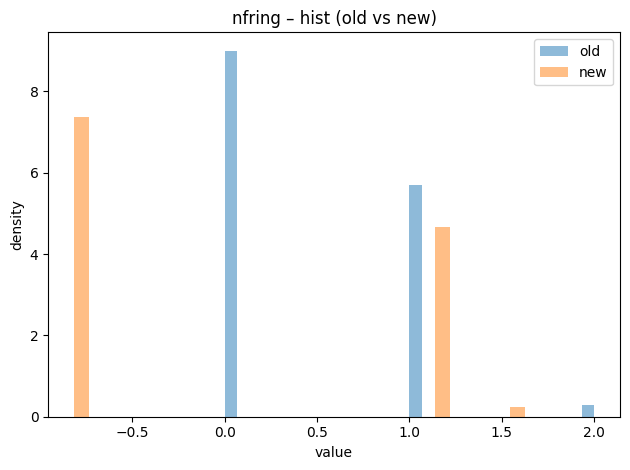

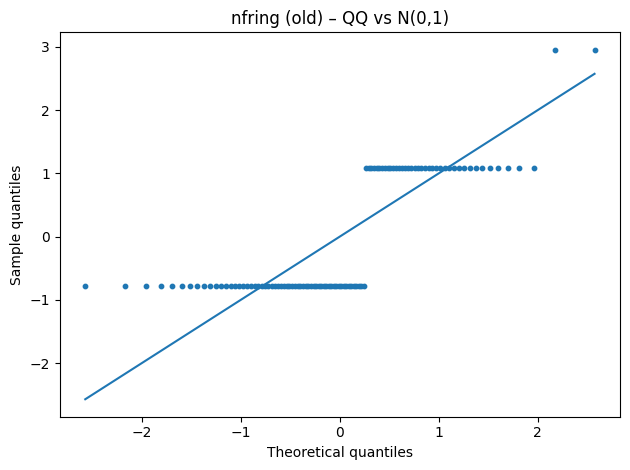

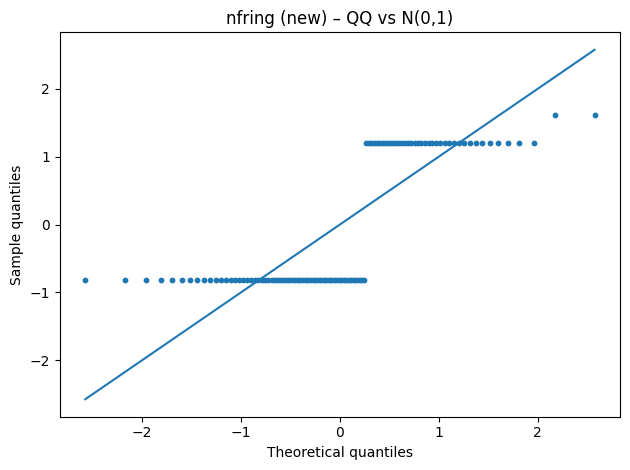

/var/folders/c_/y8b6jkqs6xqdbh11552hd04w0000gn/T/ipykernel_82207/2279482471.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, vert=True, patch_artist=True)


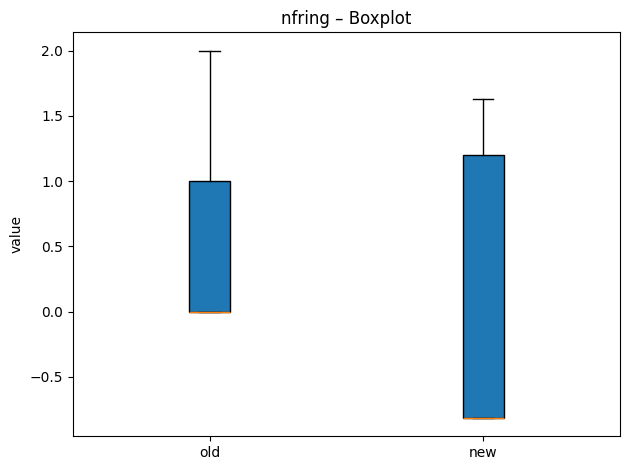

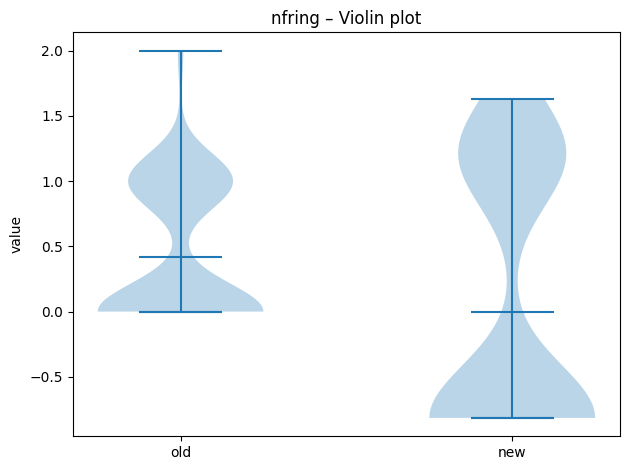

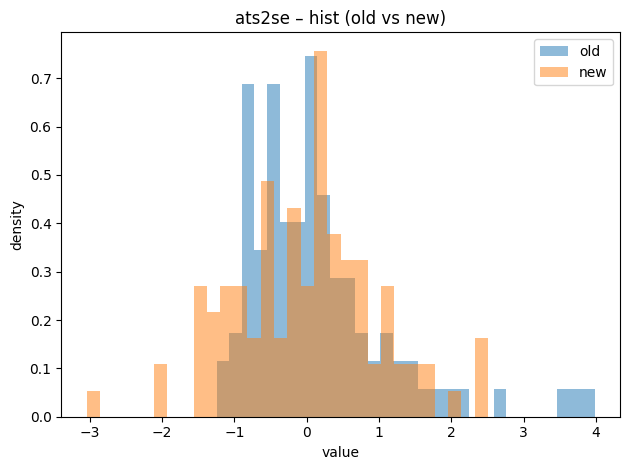

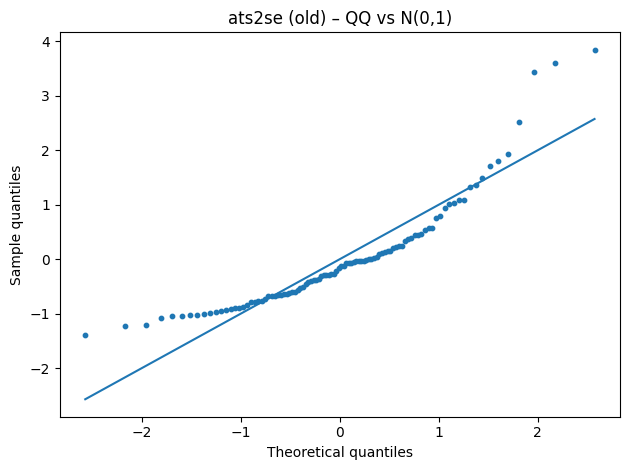

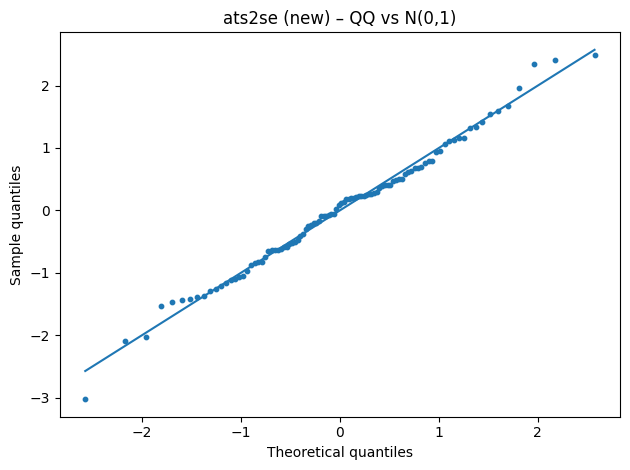

/var/folders/c_/y8b6jkqs6xqdbh11552hd04w0000gn/T/ipykernel_82207/2279482471.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, vert=True, patch_artist=True)


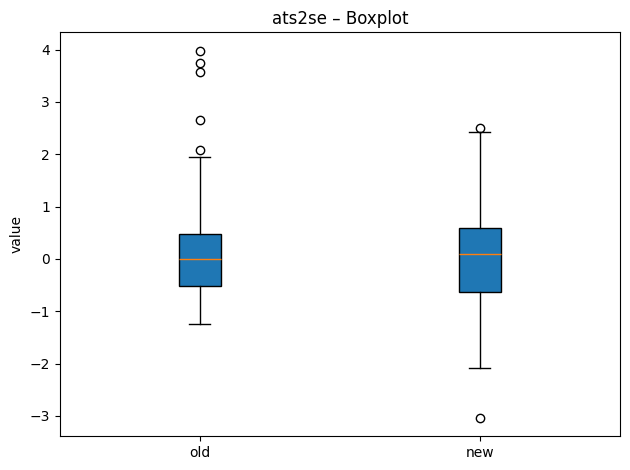

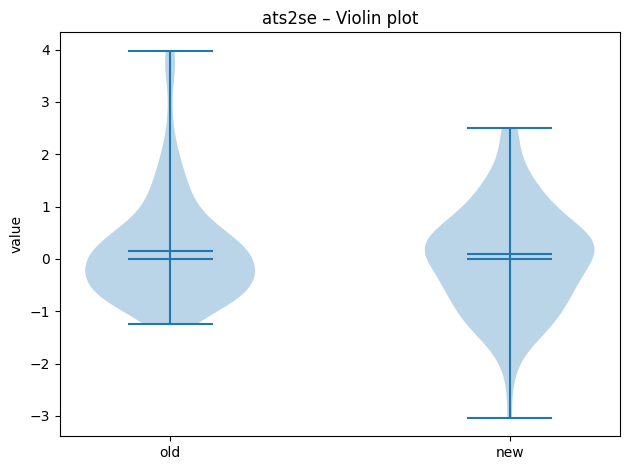

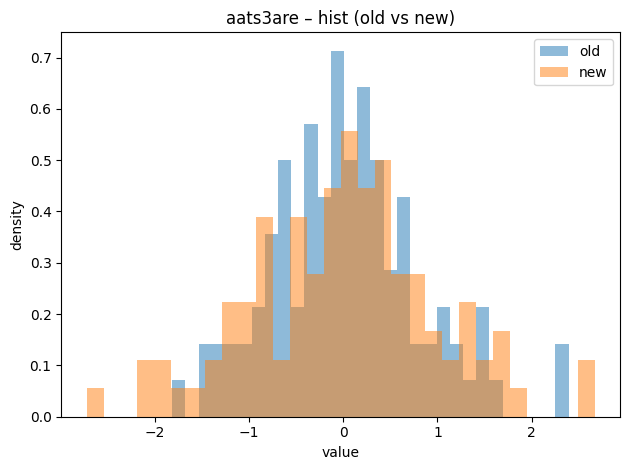

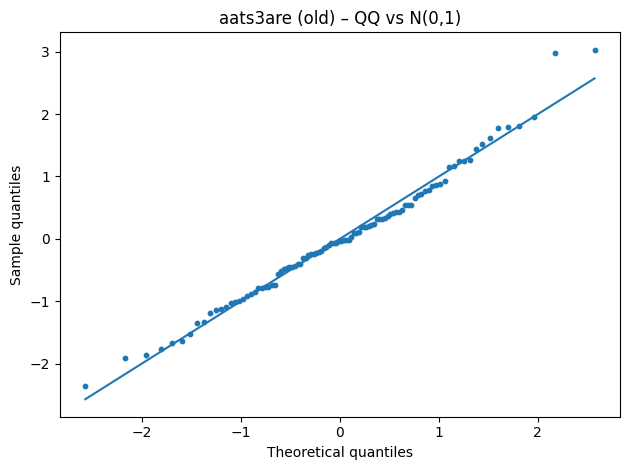

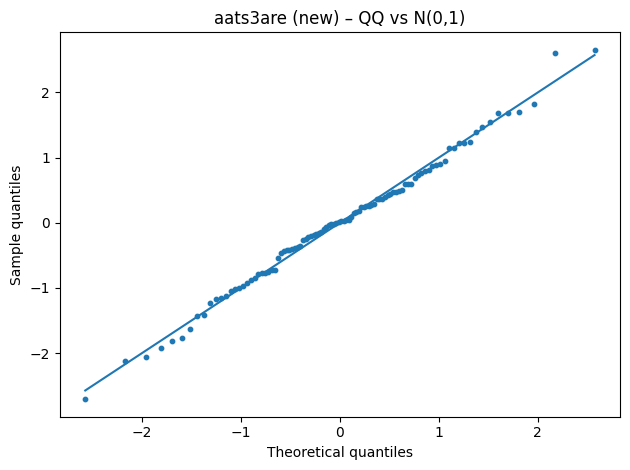

/var/folders/c_/y8b6jkqs6xqdbh11552hd04w0000gn/T/ipykernel_82207/2279482471.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, vert=True, patch_artist=True)


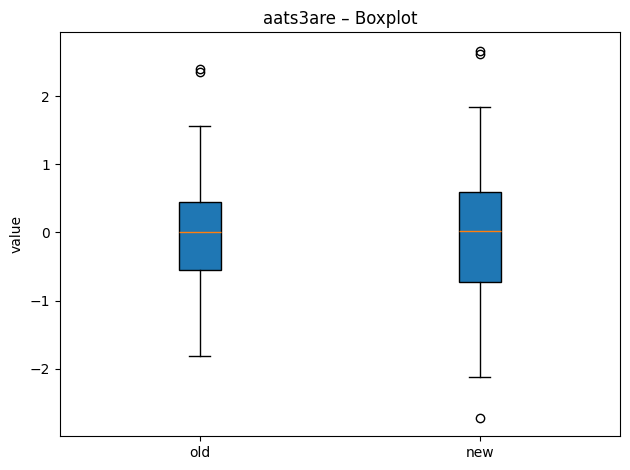

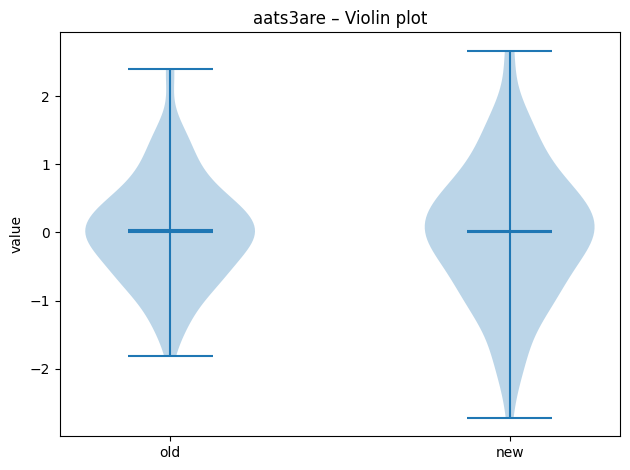

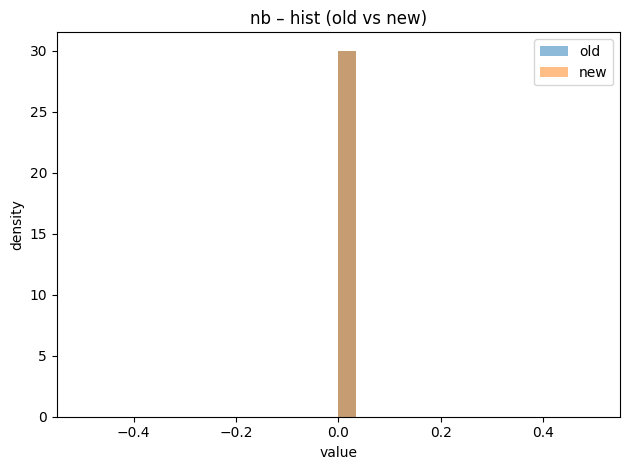

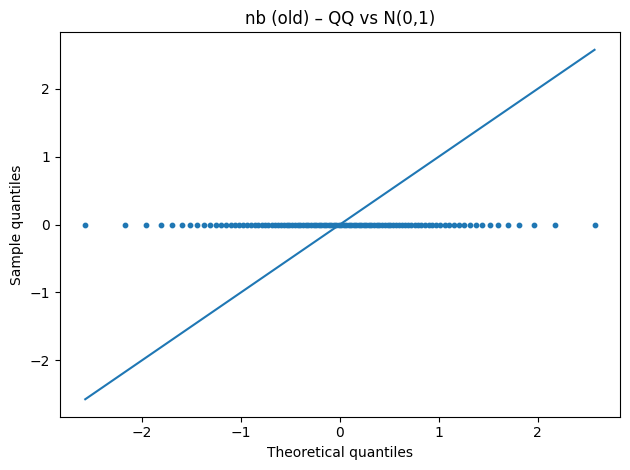

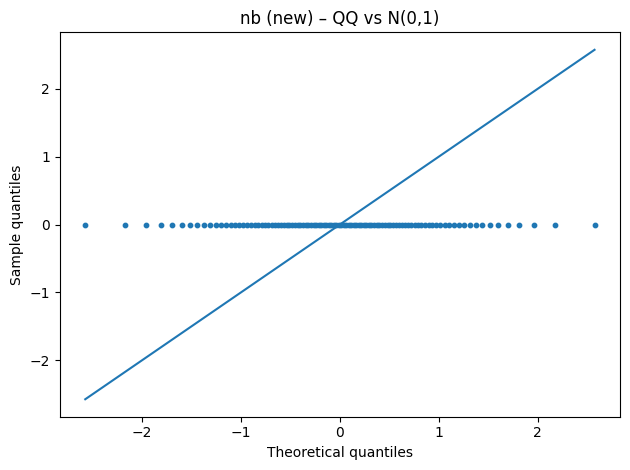

/var/folders/c_/y8b6jkqs6xqdbh11552hd04w0000gn/T/ipykernel_82207/2279482471.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, vert=True, patch_artist=True)


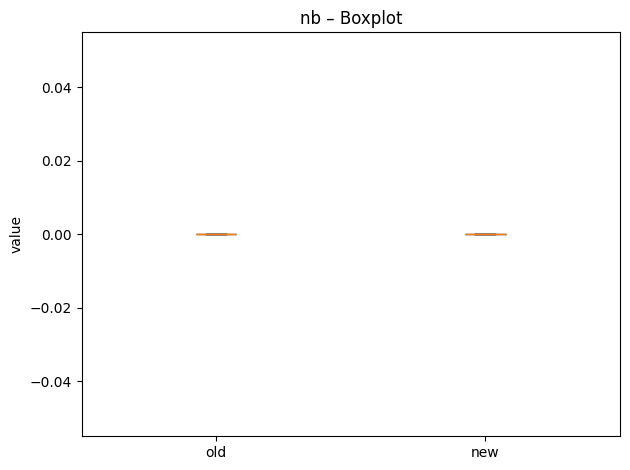

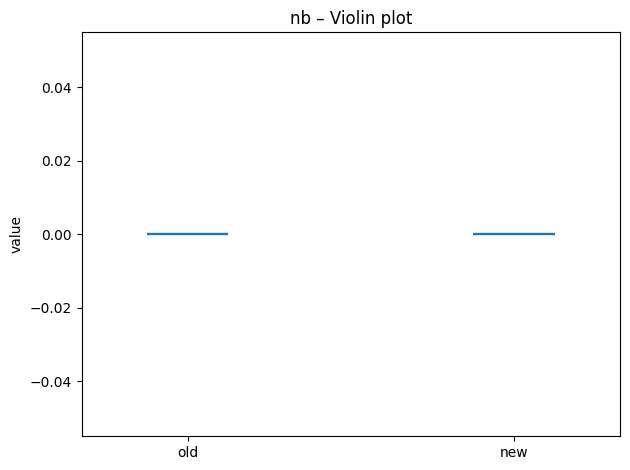

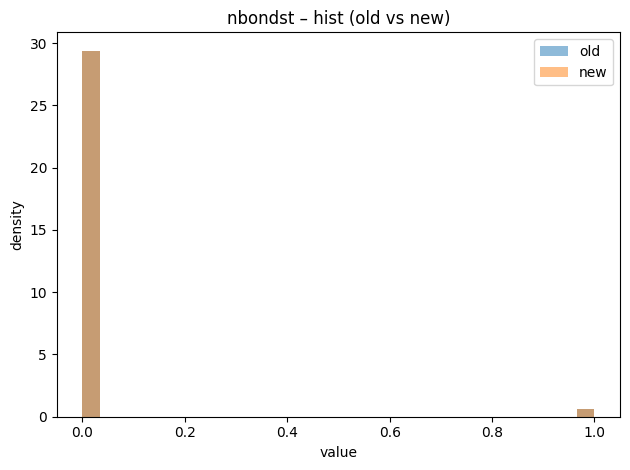

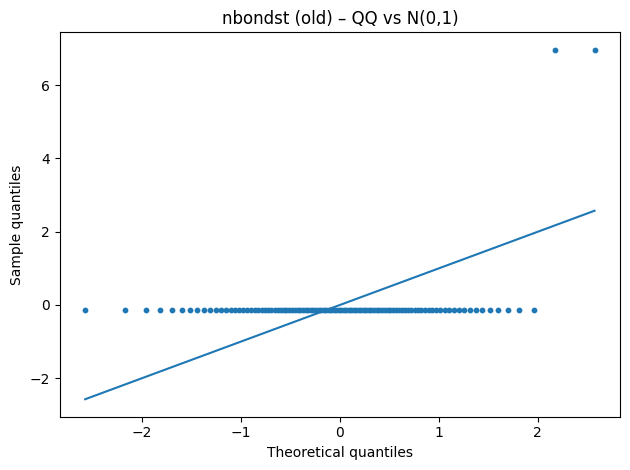

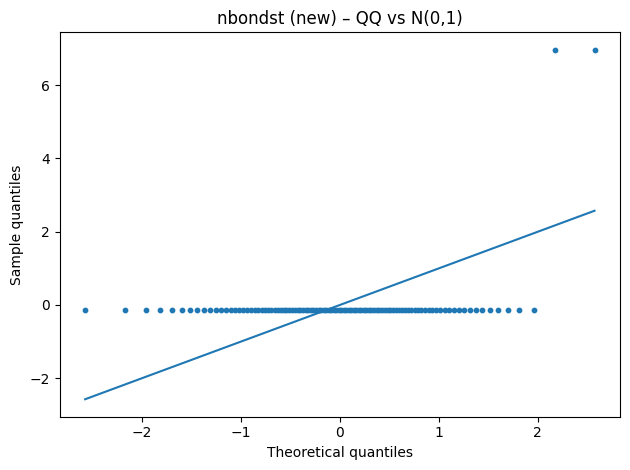

/var/folders/c_/y8b6jkqs6xqdbh11552hd04w0000gn/T/ipykernel_82207/2279482471.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, vert=True, patch_artist=True)


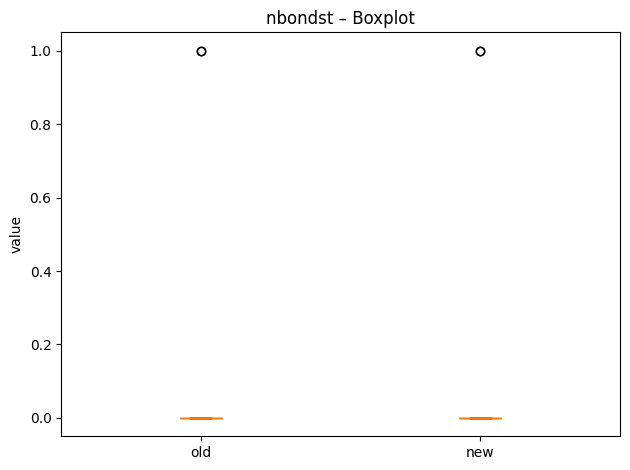

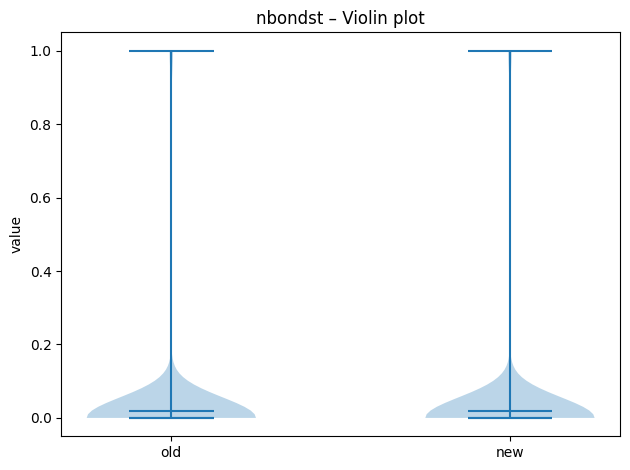


[done] Compared old robust scaling vs new typed transformer.


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data_frames.transformers.scaler import make_scaler     # old/baseline
from data_frames.transformers.build_typed_transformer import build_typed_transformer  # your new one

# ----------------------------
# 0) Load data
# ----------------------------
CSV = "drugbank_output.csv"  # change if needed
df = pd.read_csv(CSV)

# Keep only feature columns (drop id/text)
X = df.drop(columns=["key","input"], errors="ignore")

# (Optional) test with ~100 rows to speed up plots
X = X.sample(n=min(100, len(X)), random_state=42).reset_index(drop=True)

# ----------------------------
# 1) Build both preprocessors
# ----------------------------
# Old pipeline: robust scaler on numeric columns (your prior approach)
old_preproc = make_scaler(power_transform=False, robust_scaler=True)

# New pipeline: your typed transformer (groups for introspection)
new_preproc, groups = build_typed_transformer(X)

# ----------------------------
# 2) Fit and transform
# ----------------------------
# Old
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X_old_np = old_preproc.fit_transform(X[num_cols])
X_old = pd.DataFrame(X_old_np, columns=num_cols, index=X.index)

# New
X_new_np = new_preproc.fit_transform(X)
new_feature_names = list(new_preproc.get_feature_names_out())
X_new = pd.DataFrame(X_new_np, columns=new_feature_names, index=X.index)

# ----------------------------
# 3) Stats summary (before/after)
# ----------------------------
def summarize(df_in: pd.DataFrame, label: str) -> pd.DataFrame:
    desc = pd.DataFrame({
        "mean": df_in.mean(numeric_only=True),
        "std": df_in.std(numeric_only=True, ddof=1),
        "skew": df_in.skew(numeric_only=True),
        "kurtosis": df_in.kurtosis(numeric_only=True)
    })
    desc.insert(0, "pipeline", label)
    return desc

summary_old = summarize(X_old, "old_robust")
summary_new = summarize(X_new, "new_typed")

# Compare only features that exist in both (excludes one-hot-expanded integers)
common_cols = sorted(set(X_old.columns) & set(X_new.columns))
summary_old_common = summary_old.loc[common_cols].copy()
summary_new_common = summary_new.loc[common_cols].copy()

# Quick aggregate deltas over common features
delta = pd.DataFrame({
    "std_delta_abs": (summary_new_common["std"] - summary_old_common["std"]).abs(),
    "skew_delta_abs": (summary_new_common["skew"] - summary_old_common["skew"]).abs(),
    "kurt_delta_abs": (summary_new_common["kurtosis"] - summary_old_common["kurtosis"]).abs(),
})
print("=== Aggregate |Δ| over common features ===")
print(delta.mean().to_frame("mean_abs_delta"))

# Top features whose distributions changed most (by |Δ skew|)
print("\n=== Top 10 features by |Δ skew| (common) ===")
print(delta["skew_delta_abs"].sort_values(ascending=False).head(10))

# ----------------------------
# 4) Plots: per-feature comparison
# ----------------------------
def overlay_hist(old_s, new_s, title):
    # Figure 1: overlay hist (same figure, no custom colors)
    plt.figure()
    # Use density normalization so shapes are comparable
    old_s.plot(kind="hist", bins=30, alpha=0.5, density=True, label="old")
    new_s.plot(kind="hist", bins=30, alpha=0.5, density=True, label="new")
    plt.title(f"{title} – hist (old vs new)")
    plt.xlabel("value")
    plt.ylabel("density")
    plt.legend()
    plt.tight_layout()
    plt.show()

def qq_normal_plot(series, title):
    # Figure 2: QQ against standard normal (approx, no SciPy)
    s = pd.Series(series.dropna(), copy=True)
    if len(s) < 5:
        return
    s = (s - s.mean()) / (s.std(ddof=1) if s.std(ddof=1) != 0 else 1.0)

    # Theoretical quantiles for standard normal
    n = len(s)
    probs = (np.arange(1, n + 1) - 0.5) / n
    z_theory = pd.Series(np.sqrt(2) * erfinv(2*probs - 1))  # inverse CDF via erfinv

    # Sample quantiles
    s_sorted = np.sort(s.values)

    plt.figure()
    plt.scatter(z_theory, s_sorted, s=10)
    plt.plot([z_theory.min(), z_theory.max()], [z_theory.min(), z_theory.max()])
    plt.title(f"{title} – QQ vs N(0,1)")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Sample quantiles")
    plt.tight_layout()
    plt.show()

# Simple erfinv using numpy if available; fallback to approximation
try:
    from numpy import erfinv  # NumPy ≥1.17
except Exception:
    # Numerical approximation (Winitzki)
    def erfinv(x):
        a = 0.147  # Winitzki constant
        sign = np.sign(x)
        ln = np.log(1 - x**2)
        first = 2/(np.pi*a) + ln/2
        second = ln/a
        return sign * np.sqrt( np.sqrt(first**2 - second) - first )

# Pick a small set of columns to visualize:
#   - 3 from continuous (if available)
#   - 2 from counts (if available)
#   - 2 binary (if available)
cols_to_plot = []
for group_name, k in [("continuous", 3), ("counts", 2), ("binary", 2)]:
    pool = [c for c in groups.get(group_name, []) if c in common_cols]
    cols_to_plot.extend(pool[:k])

# Ensure uniqueness and existence
cols_to_plot = [c for i, c in enumerate(cols_to_plot) if c in common_cols and c not in cols_to_plot[:i]]

print("\nWill plot these common features:", cols_to_plot)

for col in cols_to_plot:
    overlay_hist(X_old[col], X_new[col], title=f"{col}")
    qq_normal_plot(X_old[col], title=f"{col} (old)")
    qq_normal_plot(X_new[col], title=f"{col} (new)")
    box_violin_plot(X_old[col], X_new[col], title=f"{col}")

# ----------------------------
# 5) One-hot’d small integers: show what changed
# ----------------------------
small_int_cols = groups.get("small_int", [])
if small_int_cols:
    for col in small_int_cols[:2]:  # show a couple to keep it light
        # Old: one scaled column
        old_series = X_old[col] if col in X_old.columns else None

        # New: many one-hot columns named like 'col_<cat>'
        new_ohe_cols = [c for c in X_new.columns if c.startswith(f"{col}_")]
        print(f"\nSmall-int feature '{col}' expanded to {len(new_ohe_cols)} columns in the new pipeline.")
        print("Example OHE columns:", new_ohe_cols[:10])

        # Plot original (hist) vs each OHE column distribution (bar of mean activation)
        if old_series is not None:
            plt.figure()
            old_series.plot(kind="hist", bins=30, alpha=0.7, density=True)
            plt.title(f"{col} (old) – hist")
            plt.xlabel("value")
            plt.ylabel("density")
            plt.tight_layout()
            plt.show()

        # Bar of activation rates per category in OHE
        act = X_new[new_ohe_cols].mean(axis=0).sort_values(ascending=False)
        plt.figure()
        act.plot(kind="bar")
        plt.title(f"{col} (new) – OHE activation rates")
        plt.xlabel("category")
        plt.ylabel("fraction of rows")
        plt.tight_layout()
        plt.show()

print("\n[done] Compared old robust scaling vs new typed transformer.")
